
## Overview

This is a demo script to illustrate the power of AGB Geospatial APIs. While retrieving and studying about AGB cover can be done in Geospatial APIs, it can also be used to find out how much the AGB cover has changed over the years.

Specifically, we will analyse the AGB cover for the Olieros area in Portugal by using the combination of Python and Geospatial APIs which in this case be used to calculate the difference in AGB cover for the years 2020 and 2021. The area that we are analyzing right now is the one that is affected by a huge wildfire on 2020-07-25. You can through the details of the wildfire and its impact [here](https://www.portugalresident.com/extraordinarily-large-extraordinarily-complex-oleiros-fire-finally-dominated/).


### Setup

Before starting, you have to install IBM EI Geospatial python SDK using `pip3 install -U ibmpairs` and the folium module ,specifically needed for this sample using `pip3 install folium`.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>

```
Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
!pip install ibmpairs
!pip install rasterio
!pip install folium

In [27]:
import ibmpairs.client as client
import ibmpairs.query as query
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import json
import rasterio
from IPython.display import display as display_summary
from IPython import display
import configparser
import folium,numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import branca.colormap as cm


Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [28]:
config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')

EI_ORG_ID     = config.get('EI', 'api.org_id') 
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_APIKEY     = config.get('EI', 'api.api_key')

EI_client_v4 = client.get_client(org_id    = EI_ORG_ID,
                                  tenant_id = EI_TENANT_ID,
                                  api_key   = EI_APIKEY,
                                  version   = 4
                                )

2024-06-25 16:28:55 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-25 16:28:55 - paw - INFO - Legacy Environment is False
2024-06-25 16:28:55 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-25 16:28:57 - paw - INFO - Authentication success.
2024-06-25 16:28:57 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v4


The following code snippet submits the query for the AGB Data Layer <i>above-ground-biomass</i>  for years 2020 and 2021 using Geospatial APIs V4 query API, waits for it to finish, downloads the data to the download folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together.

Let's go ahead, define and submit a query.

In [29]:
# submit, checks the status and downloads the result of the query (this will poll until the result is ready)
agb_historical_difference_v4_query_object = query.submit_check_status_and_download({ 
          "name": "Above Ground Biomass Difference - Portugal Olieros wildfire in 2020-07-25",
          "spatial": {
            "geojson": {
                  "type": "Feature",
                  "geometry": {"type":"MultiPolygon",                             
                            "coordinates":[[[[-7.91621713790624071, 39.97653166209390463], 
                                             [-7.72933935595677113, 39.97686418483758786], 
                                             [-7.73332962888095921, 39.79131649386284408], 
                                             [-7.91322443321309965, 39.79098397111916086], 
                                             [-7.91621713790624071, 39.97653166209390463]]]],                          
                              }   
            }
          },
          "temporal": { "years": [2020, 2021]  },
          "layers": [ { "datalayer": "above-ground-biomass" } ]
        },EI_client_v4, verify=False)

2024-06-25 16:28:57 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-25 16:28:58 - paw - INFO - The query was successfully submitted with the id: 1719273600_39538831.
2024-06-25 16:28:59 - paw - INFO - The query 1719273600_39538831 has the status Queued.
2024-06-25 16:29:30 - paw - INFO - The query 1719273600_39538831 has the status Running.
2024-06-25 16:30:01 - paw - INFO - The query 1719273600_39538831 has the status Succeeded.
2024-06-25 16:30:01 - paw - INFO - The query 1719273600_39538831 was successful after checking the status.
2024-06-25 16:30:33 - paw - INFO - The query 1719273600_39538831 has the status Succeeded.
2024-06-25 16:30:33 - paw - INFO - The query 1719273600_39538831 was successful after checking the status.
2024-06-25 16:30:33 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence-internal/geospatial_analytics/v4_apis/samples/industry_use_cases/disaster_events_deforestation/d

Let's look at the summary from the result of the query:

In [30]:
agb_historical_difference_file_list = agb_historical_difference_v4_query_object.list_files()
#This gets the folder location of where the query result is downloaded.
download_location = agb_historical_difference_v4_query_object.get_download_folder() + agb_historical_difference_v4_query_object.id
summary_file = download_location + '/' +'Above Ground Biomass-above ground biomass summary agb.json'

summary = pd.read_json(summary_file)
display_summary(summary)

,year,layer_name,area_in_ha,baseline_agb_min_units,baseline_agb_max_units,baseline_agb_mean_units,baseline_total_agb_units,baseline_total_carbon_tons,baseline_total_co2_tons,agb_analytics_type
0,2020,above-ground-biomass,32316.447073,1.08,18.00,8.055426,4181072.04,2090536.02,7.672267e+06,historical
1,2021,above-ground-biomass,32316.447073,0.18,16.65,5.621121,2917564.20,1458782.10,5.353730e+06,historical


Let's define some utility functions to display the downloaded raster tiff files.

In [31]:
pd.set_option('display.max_colwidth', None)

def now():
    return datetime.datetime.utcnow().isoformat()


def get_extent(f):
    with open(f, 'r') as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent


def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None):
    if  raster_file_name.endswith('.tiff'):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            plt.figure(figsize = (20, 12))
            if Max is None:
                Max=data.max()
            if Min is None:
                Min = data.min()
            print(Max, Min)
            plt.imshow(data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()

Let's define a function to calculate the AGB difference, display the resulting tiff and print a few related stats: 

The below method reads the two raster tiff files that are downloaded for the two yyears that we have specified in the query and calculates the difference between the two tiffs and then loads it into a new tiff file named 'Above Ground Biomass-difference.tiff'. 

During this process of creating a new tiff, it also calculates the agb density of the years 202 and 2021 and prints it out to the user.

Once we get hold of the two agb densities for the two mentioned years, we now calculate the difference in the densities and assess them to know whether the agb denstity is increased or decreased which implies whether the vegetation cover has increased or decreased over the two years.

In [32]:
def Display_AGB_difference_between_2_years(qid, display_agb_summary_file=True):
    root_folder = './download/'+str(qid)+'/'
    output_info_file = root_folder+'output.info'
    query_info = pd.read_json(output_info_file)
    sorted_files = sorted(query_info.files, key=lambda x: x["timestamp"], reverse=False)  # , reverse=True

    # for now pick up the first 2 files to calculate the increase/decrease in AGB
    older=sorted_files[0]
    latest=sorted_files[1]

    # get the older data (2020)
    older_tiff_fn=root_folder+older["name"]+".tiff"
    older_tiff_file = rasterio.open(older_tiff_fn)
    older = older_tiff_file.read(1)
    older_extent= get_extent(older_tiff_fn+'.json')

    # get the latest data (2021)
    latest_tiff_fn=root_folder+latest["name"]+".tiff"
    later_tiff_file = rasterio.open(latest_tiff_fn)
    later = later_tiff_file.read(1)

    # set nodata to 0 for the sum
    older[older==-9999] = 0
    later[later==-9999] = 0

    #calculate the older agb density total for % calculation
    older_agbd = older.sum()
    print("2020: older_agb density",older_agbd, "older_agb:",round(older_agbd*0.09,2), "older_agb carbon tons:",round(0.5*older_agbd*0.09,2))

    #calculate the latest agb density total for % calculation
    later_agbd = later.sum()
    print("2021: later_agb density",later_agbd, "later_agb:",round(later_agbd*0.09,2), "later_agb carbon tons:",round(0.5*later_agbd*0.09,2))

    #Calculate difference in AGB density  at every pixels across the whole area
    agbdensity_diff = later-older
    #Calculate difference in AGB across the whole area
    total_agbd_diff = agbdensity_diff.sum()

    AGB_Difference_tiff_file = root_folder+'Above Ground Biomass-difference.tiff'
    # Write the difference tiff file on disk
    if os.path.isfile(AGB_Difference_tiff_file):
        os.remove(AGB_Difference_tiff_file)
    with rasterio.open(AGB_Difference_tiff_file,
                   'w',
                   driver='GTiff',
                   height=agbdensity_diff.shape[0],
                   width=agbdensity_diff.shape[1],
                   count=1,
                   dtype=agbdensity_diff.dtype,
                   crs=older_tiff_file.crs,
                   transform=older_tiff_file.transform,
                   compress="lzw") as outfile:
        outfile.write(agbdensity_diff, 1)

    older_tiff_file.close()
    later_tiff_file.close()
    if total_agbd_diff<0:
        agb_assessment= "decreased:"+str(round(0.09*total_agbd_diff/0.5,2))+' ('+str(round(100*total_agbd_diff/older_agbd,2))+'%)'
    else:
        agb_assessment= "increased:"+str(round(0.09*total_agbd_diff/0.5,2))+' ('+str(round(100*total_agbd_diff/older_agbd,2))+'%)'
    print(now(), "Total Above Ground Mass Density:",agb_assessment )
    display_raster(AGB_Difference_tiff_file, 'RdYlGn', title='Above Ground Biomass density difference: '+ agb_assessment,myextent=older_extent)  
    plt.show()
    # in V3 there is no summary created to compare to.
    if display_agb_summary_file:
        AGB_info = pd.read_json(root_folder+'Above Ground Biomass-above ground biomass summary agb.json')
        display(AGB_info)

print('Display_AGB_difference_between_2_years created')

Display_AGB_difference_between_2_years created


2020: older_agb density 46473480.0 older_agb: 4182613.2 older_agb carbon tons: 2091306.6
2021: later_agb density 32430800.0 later_agb: 2918772.0 later_agb carbon tons: 1459386.0
2024-06-25T11:01:06.381569 Total Above Ground Mass Density: decreased:-2527683.66 (-30.22%)
137.0 -161.0


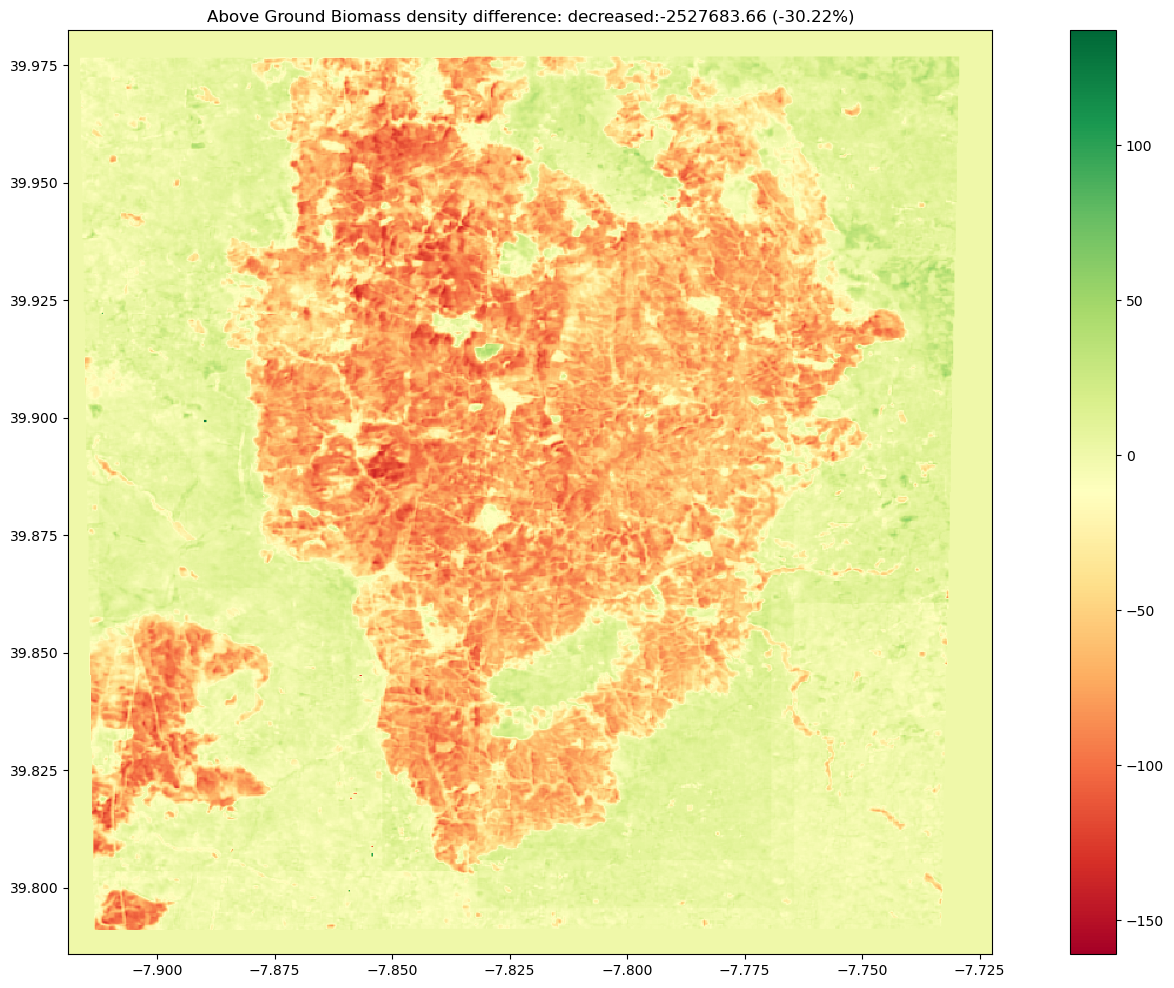

In [33]:
v4qid=agb_historical_difference_v4_query_object.get_id()
Display_AGB_difference_between_2_years(v4qid, display_agb_summary_file=False)

If you observe the output, 

- The older (2020) agb density is: 46473480.0
- The later (2021) agb denisty is: 32430800.0
- And the calculated agb density `2020-2021` is -2527683.66 which is declined by 30% from 2020 to 2021 which is a clear indication that the vegetation cover is decreased because of the wildfire that occured.

The same can be seen in the above raster tiff file, the vegetation cover from the year 2020 has gone down to a rapid extent to the year 2021. All the Red area indicate the decrease in AGB cover impacted by wildfire, and all the Green area is the area unaffected by the wildfire which has no impact in the agb cover. This demonstrates how powerful the UDF expression in Geospatial APIs is, and how complex operations can be performed with minimal user interaction.

Below is the code snippet to overlay the tiff on a world map to get an interactive visual display, after which we display the screenshot of the same for ease of rendering the notebook.

In [ ]:
#For visualizing maps
def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    cm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)   
    cmArray = []
    for i in range(vmin, vmax, 1):
        if i> vmax or i< vmin or  i == empty_val:   # i>20 or i==0:
            cmArray.insert(i,(1, 0, 0, 0)) 
        else:
            cmArray.insert(i,colors.to_rgba(cm(i), 0.8)) 
    return cmArray
cmArray = create_fast_colormap_for_range(cm.linear.RdYlGn_11, -161, 137, 0) #cm.linear.Spectral_07.scale(0,20)
agb_historical_difference_file_list = agb_historical_difference_v4_query_object.list_files()
for file in agb_historical_difference_file_list:
    if file.endswith('.tiff') and "difference" in file:
        with rasterio.open(file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            map = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=11,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon 
                    )
            data = raster.read(1)
            data[data==-9999] = np.nan_to_num(np.nan)
            data[data==0] = np.nan_to_num(np.nan)
            folium.raster_layers.ImageOverlay(
                        image=data.astype(np.uint8),opacity=0.7, 
                        colormap=lambda value: cmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(map)
            map.add_child(cm.linear.Greens_09.scale(-161, 137))
map

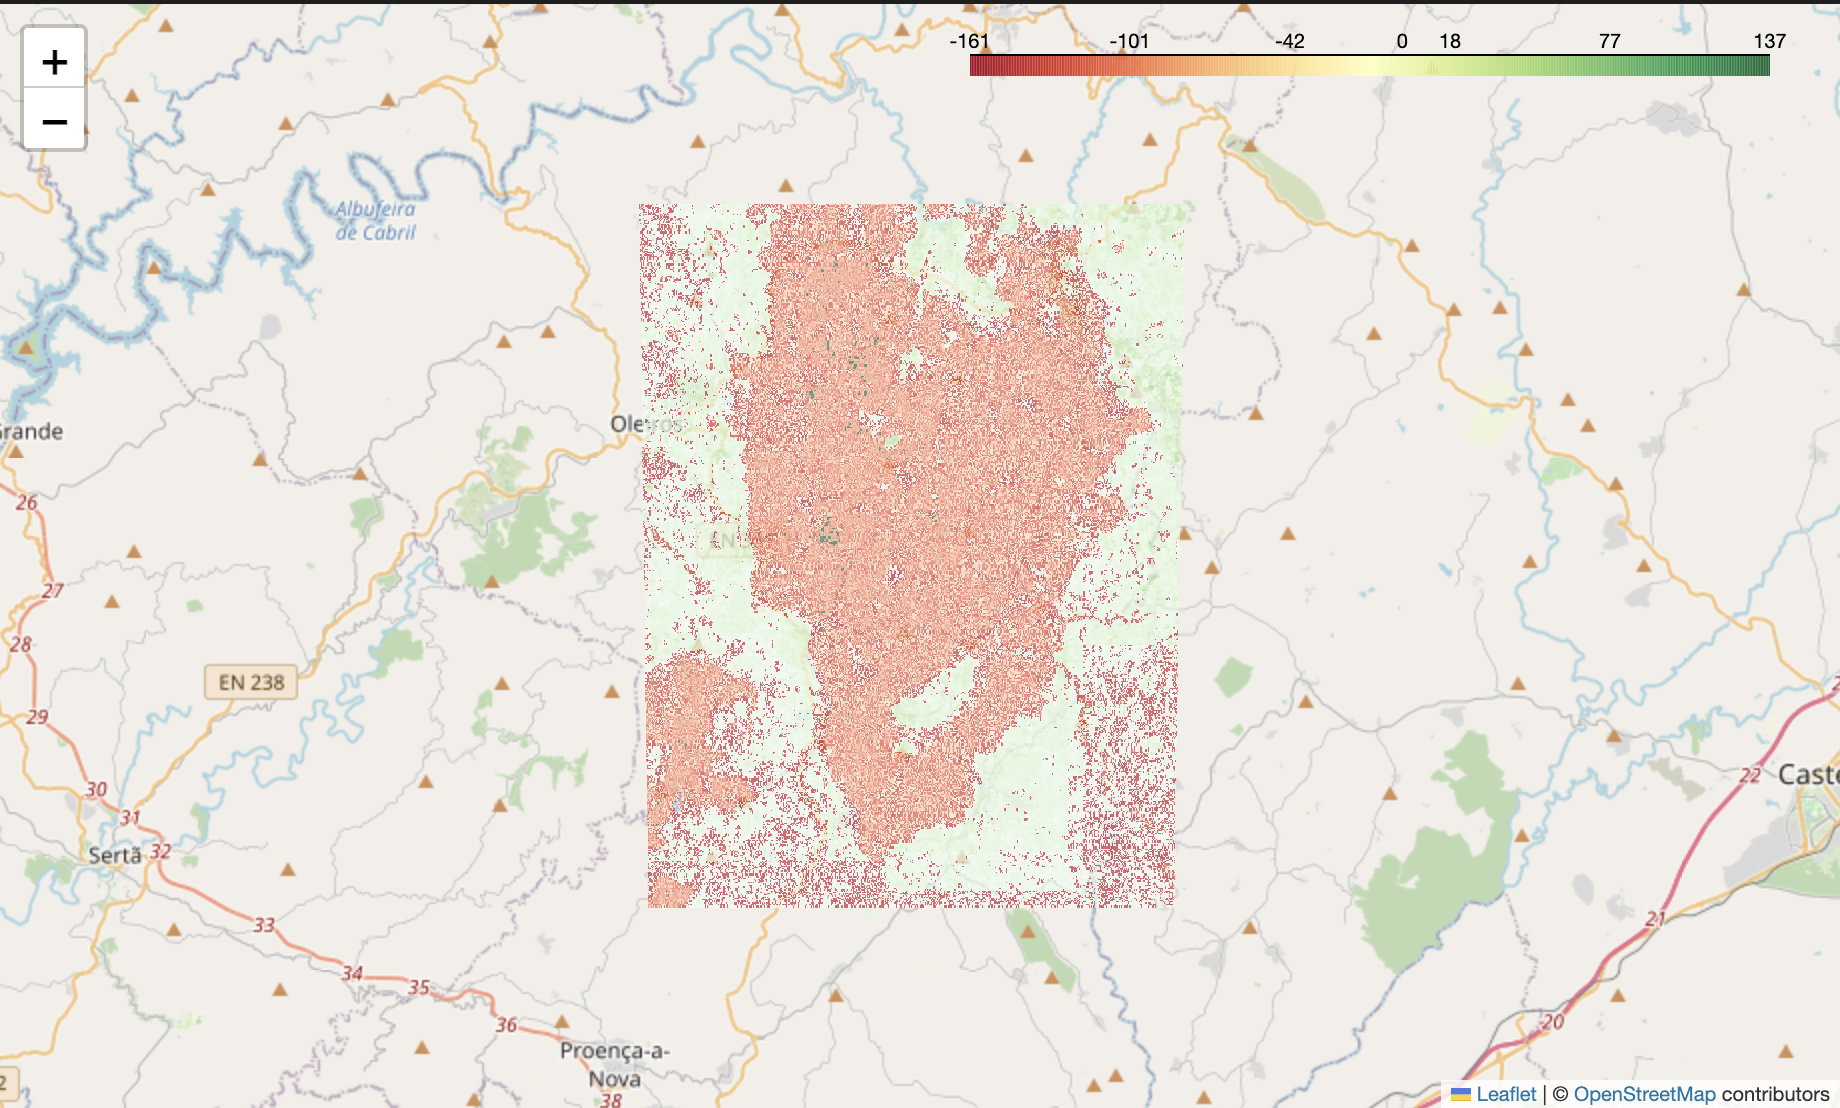

In [35]:
display.Image('historical_difference_in_agb.png')